# Welcome to Jupyter!

Enter 0 to use default value or 1 to use own
0
480.0   5748004.880016568
184.65089440276975   847784.0408116089
114.31293165039295   323829.18545643915
82.78002931792705   169246.3140723293
64.882400648824   103622.45444244443
53.34815226451792   69818.3911177559
45.29583844484288   50160.91893213278
39.35555282253105   37738.31019785286
34.79269353435779   29393.988614990783
31.17794160631353   23522.437472749374
28.243601059135038   19236.93292386072
25.814084810024468   16014.604052693749
23.769436466277114   13530.94146526761
22.02491568586964   11577.039322110484
20.51895866284786   10012.925412867758
19.205761728518556   8741.677520756872
18.050541516245488   7694.65837345129
17.026408669279746   6822.211640339071
16.112248665704406   6087.75712800568
15.291250537583027   5463.7065347706675
14.549863595028796   4928.920630009681
13.8770436115006   4467.84466422817
13.263698914034652   4066.793876388437
12.702277147809518   3716.4991746013193
12.186452726718798   3408.378414776654

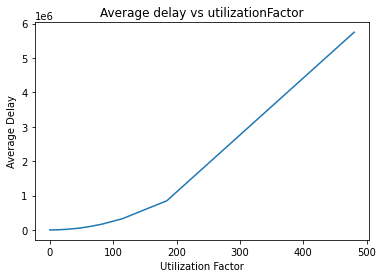

In [1]:
import matplotlib.pyplot as plt
import queue as Q

# Simulating for fixed time
# EVENTS0 = generation of packet
# EVENTS1 = reaching Queue time
# EVENTS2 = leaving queue time
# EVENTS3 = reaching sink time
    
    
# class for source
class SOURCEINFO:
    def __init__(self, lamda, sid, bandSoSwi):
        self.genRate = lamda        # Here we have taken the generation rate as lamda as given
        self.sourceId = sid         # Every Source has a unique source id
        self.bandSoSwi = bandSoSwi  # It is the bandwidth of source to switch

# class for switch
class SWITCHINFO:
    def __init__(self, bwidth):
        self.bandSwSin = bwidth     # It is the bandwidth of switch to sink
        self.qSize = 0              # Initally in the class we take the size as 0
        

# class for packet
class PACKETINFO:
    def __init__(self, pid=0, gtime=0.0, sourceid=0):
        self.packetId = pid         # We define every packet with a unique packet id
        self.queueIn = -1           # The time the packet gets in the queue
        self.queueOut = -1          # The time the packet gets out of the queue
        self.sinkReachTime = -1     # The time it reaches teh sink
        self.sourceId = sourceid    # The sourceid of the source from where the packet was generated
        self.generationTime = gtime # The time it was generated
        


# class for various EVENTS
class EVENTS:
    def __lt__(self, other):
        return self.currentTime < other.currentTime
        
    def __init__(self, eid, pid, t):
        self.eId = eid
        self.pId = pid
        self.currentTime = t

utilization = 0   #It measures the utilility

# function to calculate avg delay
# We are calculating the time taken by each packet to reach teh sink
# This time is basically the delay because of the switch wasnot there then the time taken
# would have been 0. So all the time that a packet is taking now is the delay
# And for the average we will sumation of all the delays divided by the total no of packets

def avgDelayFunction(nSource, bandSoSwi, bandSwSin, pktLength, source,simulationTime):
    packet = []                   #It will contain the information about all the packets
    avgDelay = 0.0                # Initially the average delay is 0
    switchInt = SWITCHINFO(bandSwSin) # declares a variable of the class SWITCHINFO with give bandwidth
    
    # We will generate first packet from every source at an fixed interval
    totaltime = 0.0

    # now we declare a priority queue
    # It adjusts the objects acording to the current time of the events
    pq = Q.PriorityQueue()
    
    # We will iterate for all the sources 
    for i in range(nSource):
        packet.append(PACKETINFO(i, totaltime, i))  # We record all the information about our pavket in our packet array
        pq.put(EVENTS(0, i, totaltime))
        totaltime += 0.000001

    pcount = 0
    simulationTime=5000
    pktTot = nSource
    lastLeftTime = 0.0
    currentTime = 0
    packet_sink = 0
    
    #We will iterate the loop until the pkt reaching sink is not gretaer than the simulation time
    while (packet_sink < simulationTime):
        topPacket = pq.get()
        pid = topPacket.pId
        currentTime = topPacket.currentTime
        
        # EVENTS 0 -> (EVENTS0,EVENTS1)
        # first we see for our event 0->1 ie genration of packet and reaching the queue
        # here we take the rate of generation rate lamda and then append in packet array the details of the packet
        # after that we increment totalpackets with 1 and we populate our priority queue for the record
        # At last we give our queue the data of current time + our packetlength/ bandwidth of that stage
        if topPacket.eId == 0:
            rate = source[packet[pid].sourceId].genRate
            pq.put(EVENTS(0, pktTot, currentTime + 1 / rate))
            packet.append(PACKETINFO(pktTot, currentTime + 1 / rate, packet[pid].sourceId))
            pktTot += 1
            flagSoSwi = pktLength / bandSoSwi
            pq.put(EVENTS(1, pid, currentTime + flagSoSwi))
            packet[pid].queueIn = currentTime + flagSoSwi
            
        # EVENTS 1 -> EVENTS2
        # now for event 1->2 ie entering to levaing the queue
        # we define a reaching time i.r the queusize * the length fo teh packet and we dive it by our bandwidth
        # On the basis if the last packet levaing te queue we decare a value to variable for time taken
        # Then e populate our priority queue for this time of event 2
        # and since one packet has now left teh queue we increment our actual total packet received and the queue size with 1
         
        elif topPacket.eId == 1:
            reachTime = switchInt.qSize*pktLength
            reachTime = reachTime/bandSwSin
            addTime=0
            flag1=(pktLength / bandSwSin)
            if packet[pid].queueIn - lastLeftTime < flag1:
                addTime = max(0, flag1 - (packet[pid].queueIn - lastLeftTime))
            if lastLeftTime == 0:
                addTime = 0
            pq.put(EVENTS(2, pid, currentTime + reachTime + addTime))
            packet[pid].queueOut = currentTime + reachTime + addTime
            avgDelay += packet[pid].queueOut-packet[pid].generationTime+flag1
            switchInt.qSize += 1
            pcount += 1
            
        # EVENTS2 -> EVENTS3
        # thsi is for event2->3 ie leaving the queue and reaching teh sink
        # first we decrease the queue size by 1 as the packet is now not in the queue
        # Then according to the time and packet id, and bandwidth we popuate our sink recahing time in the prioirty queu
        elif topPacket.eId == 2:
            switchInt.qSize = switchInt.qSize - 1
            lastLeftTime = currentTime
            flag2 = pktLength / bandSwSin
            sinkTime = currentTime + flag2
            packet[pid].sinkReachTime = sinkTime
            pq.put(EVENTS(3, pid, sinkTime))
            
        # thsis for the last stage where the packet reaches the sink
        # Here we simply increment the n of packet at sink by 1
        else:
        	packet_sink +=1

	# the average delay is the sum of all average delays divided by the total no of packets
    avgDelay = avgDelay / pcount
    return avgDelay


def main():

    print ("Enter 0 to use default value or 1 to use own")
    resp = int(input())
    if resp == 0:
        # nsource = number of source
        nSource = 5

        # bandSoSwi = bandwidth between source and switch in bit
        bandSoSwi = 2e6

        # bandSwSin = bandwidth between switch and sink in bit
        bandSwSinHigh = 8e7
        bandSwSinLow = 25e3
        # pktLength = size of each packet in bit
        pktLength = 1.2e5

        #packetGenerate = packet genrate
        packetGenerate = 20

        #simulation time
        simulationTime = 5000
    else :

        nSource = int(input("Enter The Number of Sources :"))
        bandSoSwi = float(input("Enter the bandwdth between the Source and switch(bandSoSwi) in bit:"))
        bandSwSinLow = float(input("Enter the bandwidth(lower bound) between the switch and sink(bandSwSin) in bit:"))
        bandSwSinHigh = float(input("Enter the bandwidth(upper bound) between the switch and sink(bandSwSin) in bit:"))
        pktLength = int(input("Enter the packet length in bit(pktlength) :"))
        packetGenerate = int(input("Enter the packet generation rate(considered same for all) for source:"))
        if pktLength*packetGenerate >= bandSoSwi:
            print("pktLength*packetGenerated should be less than bandwidth Between Source and Switch")
            return 0
        simulationTime =int(input("Enter the Simulation time:"))

    # utilization = numerator of utilization factor i.e arrival rate
    global utilization
    # topPacket and y holds value of delay and utilizationfactor
    x = []
    y = []

    # creating source object
    source = []
    for i in range(nSource):
        source.append(SOURCEINFO(packetGenerate, i, bandSoSwi))
        utilization += packetGenerate

    newbandSwSin = bandSwSinLow
    # varying newbandSwSin i.e bandSwSin for plotting
    while (newbandSwSin<=bandSwSinHigh):
        loadfactor = utilization * pktLength
        loadfactor = loadfactor / newbandSwSin
        avgDelay = avgDelayFunction(nSource, bandSoSwi, newbandSwSin, pktLength, source,simulationTime)
        x.append(loadfactor)
        y.append(avgDelay)
        print(loadfactor, " ", avgDelay)
        if(loadfactor>1):
        	newbandSwSin += (bandSwSinHigh-bandSwSinLow)/2000 
        else:
        	newbandSwSin += (bandSwSinHigh-bandSwSinLow)/150
       
    # plotting curve
    plt.plot(x, y)
    plt.xlabel("Utilization Factor")
    plt.ylabel("Average Delay")
    plt.title("Average delay vs utilizationFactor")
    plt.show()


if __name__ == "__main__":
    main()